# Geo-oefendag Hyperspectral satellite imagery 14-07-2023

## Useful resources:
Useful paper: Application of Spectral Mixture Analysis to Vessel Monitoring Using Airborne Hyperspectral Data

Useful link: https://www.imagelab.at/help/vca_ui.htm

We may have stolen from this:
https://notebook.community/anugrah-saxena/pycroscopy/jupyter_notebooks/Spectral_Unmixing_2pos_1spe

## Setup

### Importing packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import rasterio
from rasterio.plot import show

import tifffile

from bs4 import BeautifulSoup

import rioxarray

from lxml import etree

import sklearn
# multivariate analysis:
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from pysptools import eea
import pandas as pd

import spectral

## Exploring Ijmuiden and area

### Setting the paths for the Ijmuiden-imagery (change your root_path if you have issues loading in the data)

In [6]:
image_name = "ENMAP01-____L2A-DT0000004850_20221026T112131Z_005_V010201_20230421T172449Z-SPECTRAL_IMAGE.TIF"
root_path = "ENMAP01-____L2A-DT0000004850_20221026T112131Z_005_V010201_20230421T172449Z"
metadata_path = "ENMAP01-____L2A-DT0000004850_20221026T112131Z_005_V010201_20230421T172449Z-METADATA.XML"

### Using our metadata to gain the wavelength center value,  Full WidtH at Half Maximum for each band and each band's gain

The latter we'll use to correct values on each band when we use it

In [7]:
meta = etree.parse(os.path.join(root_path, metadata_path))

bandStatistics = pd.DataFrame.from_dict({
    elem.xpath("@number")[0]: {
        "wavelength": float(elem.xpath("wavelengthCenterOfBand/text()")[0]),
        "FWHMOfBand": float(elem.xpath("FWHMOfBand/text()")[0]),
        "GainOfBand": float(elem.xpath("GainOfBand/text()")[0])
    }
    for elem in meta.xpath('/level_X/specific/bandCharacterisation/bandID')
},orient="index")

### Loading the data

In [45]:
src = rasterio.open(os.path.join(root_path, image_name))
src_array = src.read()

### We'll set the axes to allow for visualisation with Matplotlib
src_array = np.swapaxes(src_array, 0, 2)
src_array = np.swapaxes(src_array, 0, 1)

### We will also make sure to encode missing values as 0, instead of the default -32768
src_array[src_array==-32768] = 0

### Creating a True Colour Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1235.5, 1211.5, -0.5)

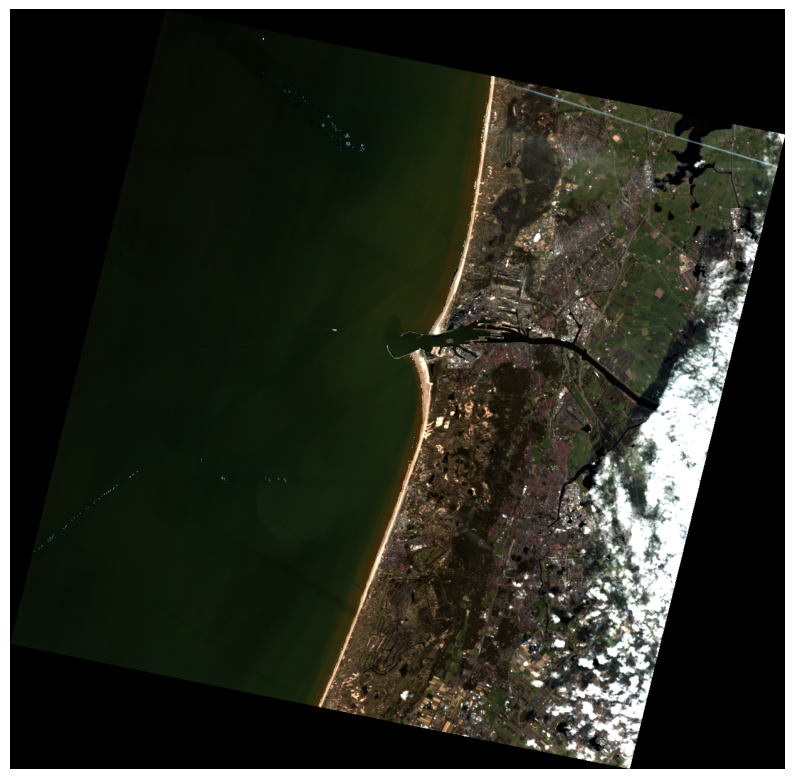

In [37]:
red = src_array[:, :, 40] * bandStatistics["GainOfBand"][40]
green = src_array[:, :, 21] * bandStatistics["GainOfBand"][22]
blue = src_array[:, :, 9] * bandStatistics["GainOfBand"][12]

TCI = np.stack([red * 0.95, green, blue], axis=2)

alpha = 5 # The alpha value here is used to add more contrast to the colours on our image, making it prettier!

fig, ax = plt.subplots(1,1, figsize=(10,10))
plt.imshow(TCI*alpha)
plt.axis("off")

#### Zooming in 

See that the resolution of EnMAP is somewhat low?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 99.5, 99.5, -0.5)

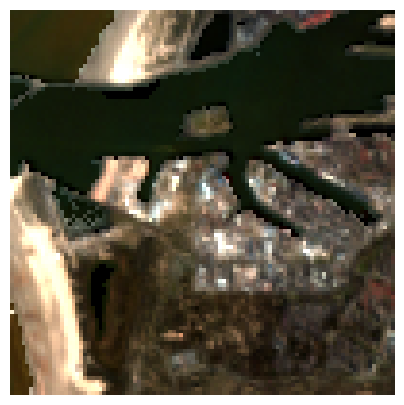

In [36]:
sample = src_array[500:600, 650:750, :]
red = sample[:, :, 40] * bandStatistics["GainOfBand"][40]
green = sample[:, :, 21] * bandStatistics["GainOfBand"][22]
blue = sample[:, :, 9] * bandStatistics["GainOfBand"][12]

TCI = np.stack([red * 0.95, green * 1, blue * 1], axis=2)
alpha = 5
fig, ax = plt.subplots(1,1, figsize=(5,5))
plt.imshow(TCI*alpha)
plt.axis("off")

### Analysing the refraction of light on 3 different surfaces (a single pixel of urban, water, vegetation terrain) for each band

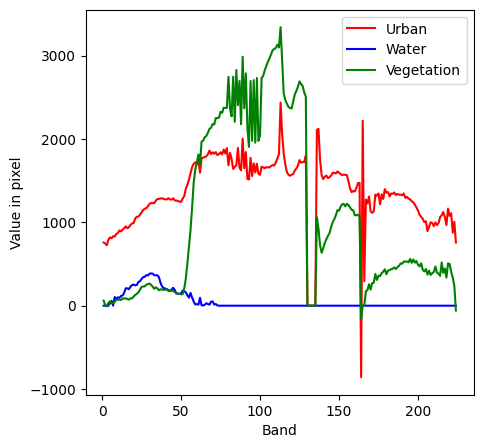

In [21]:
single_pixel_1 = src_array[550, 700, :]
single_pixel_2 = src_array[400, 600, :]
single_pixel_3 = src_array[840, 750, :]

bands = range(1, src_array.shape[2] +1)

fig, ax = plt.subplots(1,1,figsize=(5,5))
plt.plot(bands, single_pixel_1, c="red")
plt.plot(bands, single_pixel_2, c="blue")
plt.plot(bands, single_pixel_3, c="green")

ax.set_xlabel("Band")
ax.set_ylabel("Value in pixel")

plt.legend(["Urban", "Water", "Vegetation"])

print("")

This matches the profile stated below from a recent paper (https://www.researchgate.net/figure/Spectral-signatures-as-functions-of-wavelength-for-five-typical-surfaces-The-central_fig4_318843407) quite well:

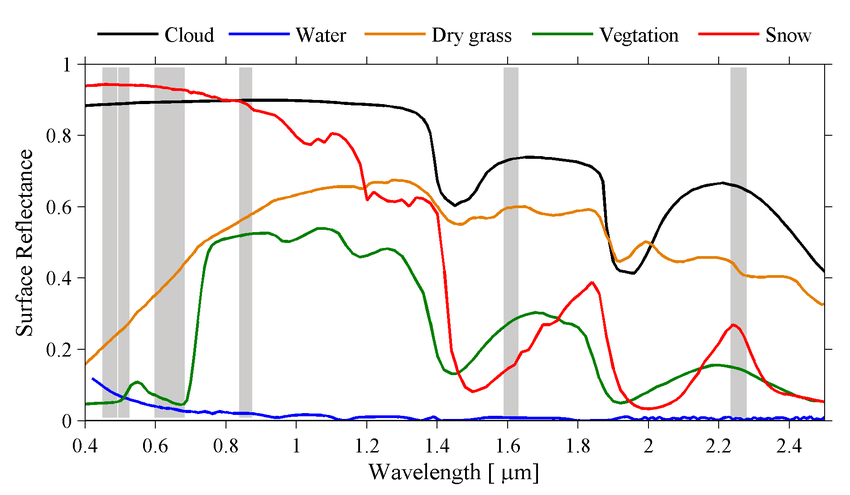

### Look at this pretty picture!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1235.5, 1211.5, -0.5)

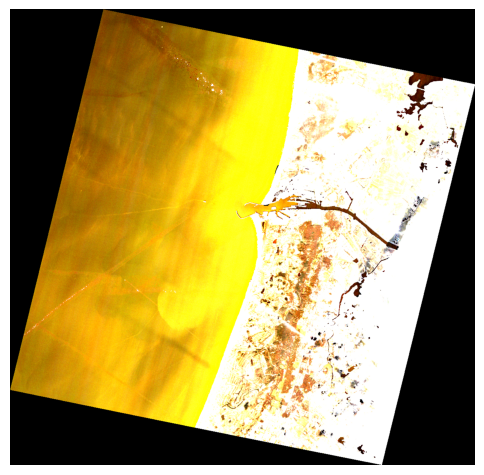

In [28]:
red = src_array[:, :, 34]
green = src_array[:, :, 20]
blue = src_array[:, :, 6]

false_coL_img = np.stack([red, green, blue], axis=2)

fig, ax = plt.subplots(1,1, figsize=(6,6))
plt.imshow(false_coL_img)
plt.axis("off")

## Exploring Den Helder and nearby area, as well as part of Texel

We'll start testing algorithms here!

### Setting path for Den Helder

In [38]:
image_name = "ENMAP01-____L2A-DT0000004850_20221026T112122Z_003_V010201_20230421T172451Z-SPECTRAL_IMAGE.TIF"
root_path = "den_helder"
metadata_path = "ENMAP01-____L2A-DT0000004850_20221026T112122Z_003_V010201_20230421T172451Z-METADATA.XML"

### Loading in metadata

In [40]:
meta = etree.parse(os.path.join(root_path, metadata_path))

bandStatistics = pd.DataFrame.from_dict({
    elem.xpath("@number")[0]: {
        "wavelength": float(elem.xpath("wavelengthCenterOfBand/text()")[0]),
        "FWHMOfBand": float(elem.xpath("FWHMOfBand/text()")[0]),
        "GainOfBand": float(elem.xpath("GainOfBand/text()")[0])
    }
    for elem in meta.xpath('/level_X/specific/bandCharacterisation/bandID')
},orient="index")

### Loading in imagery

In [46]:
src = rasterio.open(os.path.join(root_path, image_name))
src_array = src.read()
src_array = np.swapaxes(src_array, 0, 2)
src_array = np.swapaxes(src_array, 0, 1)
src_array[src_array==-32768] = 0

### Making a nice TCI for Texel and area

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1235.5, 1210.5, -0.5)

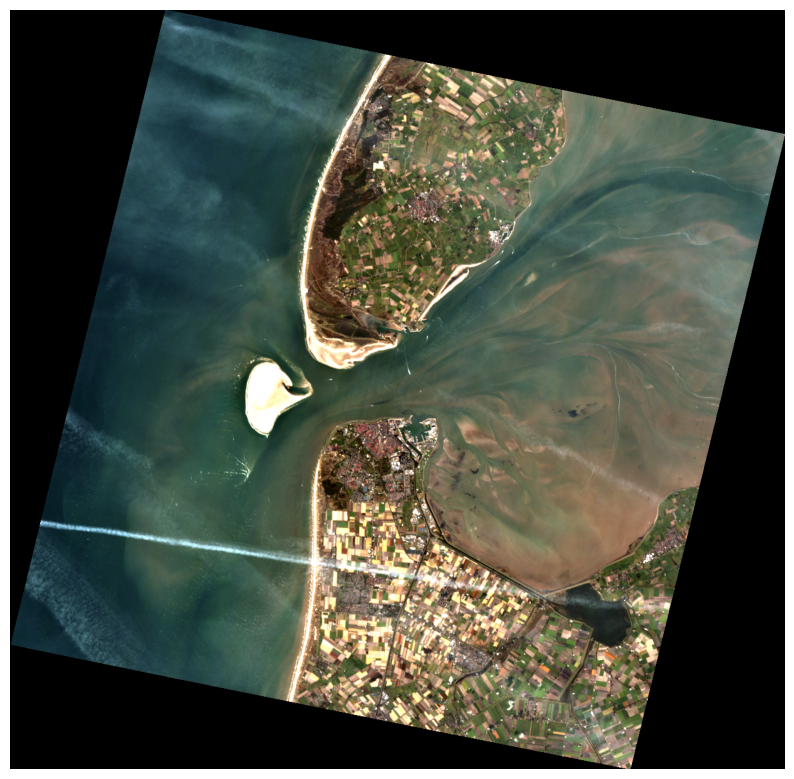

In [54]:
red = src_array[:, :, 40] * bandStatistics["GainOfBand"][40]
green = src_array[:, :, 21] * bandStatistics["GainOfBand"][22]
blue = src_array[:, :, 9] * bandStatistics["GainOfBand"][12]

TCI = np.stack([red, green, blue], axis=2)

alpha = 8

fig, ax = plt.subplots(1,1, figsize=(10,10))
plt.imshow(TCI*alpha)
plt.axis("off")

#### Zooming in

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


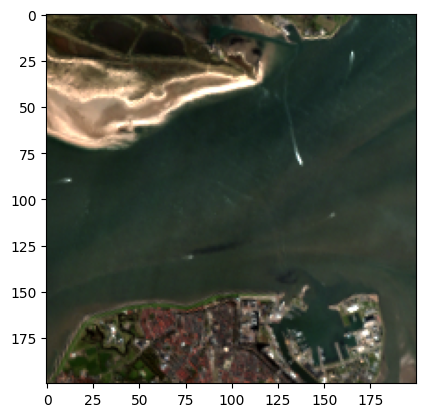

In [48]:
src_array_zoomed = src_array[400:800, 400:800, :]
src_array_further_zoomed = src_array_zoomed[100:300, 100:300, :]

red = src_array_further_zoomed[:, :, 40]
green = src_array_further_zoomed[:, :, 22]
blue = src_array_further_zoomed[:, :, 12]

TCI = np.stack([red * 0.95, green * 1, blue * 1], axis=2)

plt.imshow(TCI * 0.0005)

## Testing Algorithms

### K-Means Clustering

A classic, specifically adjusted to allow hyperspectral imagery to be processed. Seriously, the Spectral-package is awesome... 

In [99]:
num_comps = 12

result = spectral.kmeans(src_array, num_comps, 40)

spectral:INFO: k-means iteration 1 - 1496796 pixels reassigned.
spectral:INFO: k-means iteration 2 - 181601 pixels reassigned.
spectral:INFO: k-means iteration 3 - 68448 pixels reassigned.
spectral:INFO: k-means iteration 4 - 62313 pixels reassigned.
spectral:INFO: k-means iteration 5 - 45510 pixels reassigned.
spectral:INFO: k-means iteration 6 - 36618 pixels reassigned.
spectral:INFO: k-means iteration 7 - 31425 pixels reassigned.
spectral:INFO: k-means iteration 8 - 24700 pixels reassigned.
spectral:INFO: k-means iteration 9 - 19534 pixels reassigned.
spectral:INFO: k-means iteration 10 - 19496 pixels reassigned.
spectral:INFO: k-means iteration 11 - 19659 pixels reassigned.
spectral:INFO: k-means iteration 12 - 18863 pixels reassigned.
spectral:INFO: k-means iteration 13 - 16986 pixels reassigned.
spectral:INFO: k-means iteration 14 - 14270 pixels reassigned.
spectral:INFO: k-means iteration 15 - 12333 pixels reassigned.
spectral:INFO: k-means iteration 16 - 11372 pixels reassigned

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1235.5, 1210.5, -0.5)

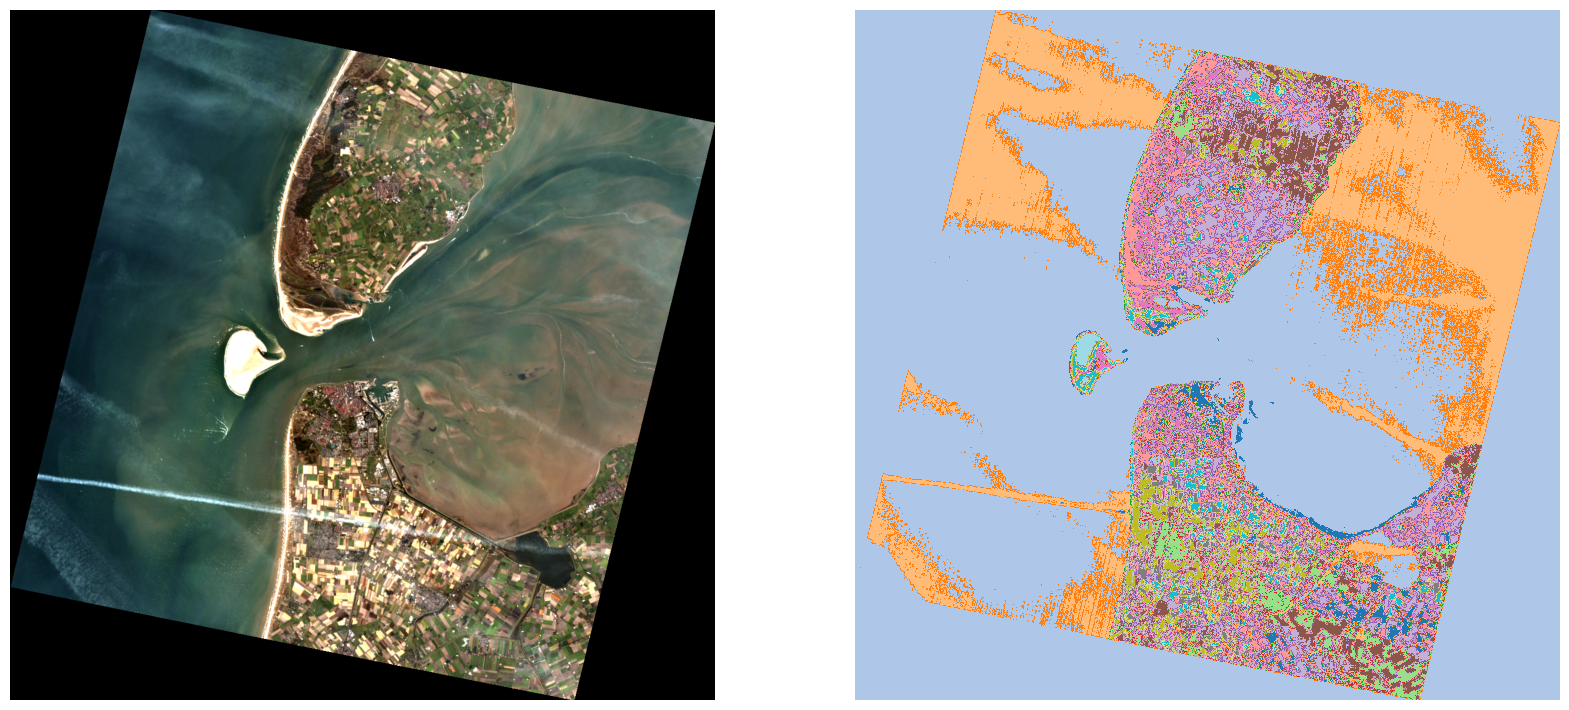

In [100]:
classes = result[0]

fig, axs = plt.subplots(1,2,figsize=(20,40))
axs[0].imshow(TCI*alpha)
axs[0].axis("off")
axs[1].imshow(classes,cmap="tab20",alpha=1)
axs[1].axis("off")


### NFINDER

NFINDER is an algorithm that identifies the optimal bands to detect components (called "endmembers") that it determines are present within the image with.

These endmembers are essentially objects that share a certain level of similarity, not unlike the cluster of the K-Means above, or Principal Components. NFINDER identifies these, as well as the optimal bands to find and visualise them with (i.e. those bands within which the most variance can be found given the pixels that are part of the detected endmember). 

In [91]:
num_comps = 6

nfindr = eea.NFINDR()
U = nfindr.extract(src_array, num_comps, normalize=True, ATGP_init=False)

In [92]:
bands = np.argmax(U, axis=1)

In [93]:
bands

array([ 85, 112, 136, 163, 163, 112], dtype=int64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1235.5, 1210.5, -0.5)

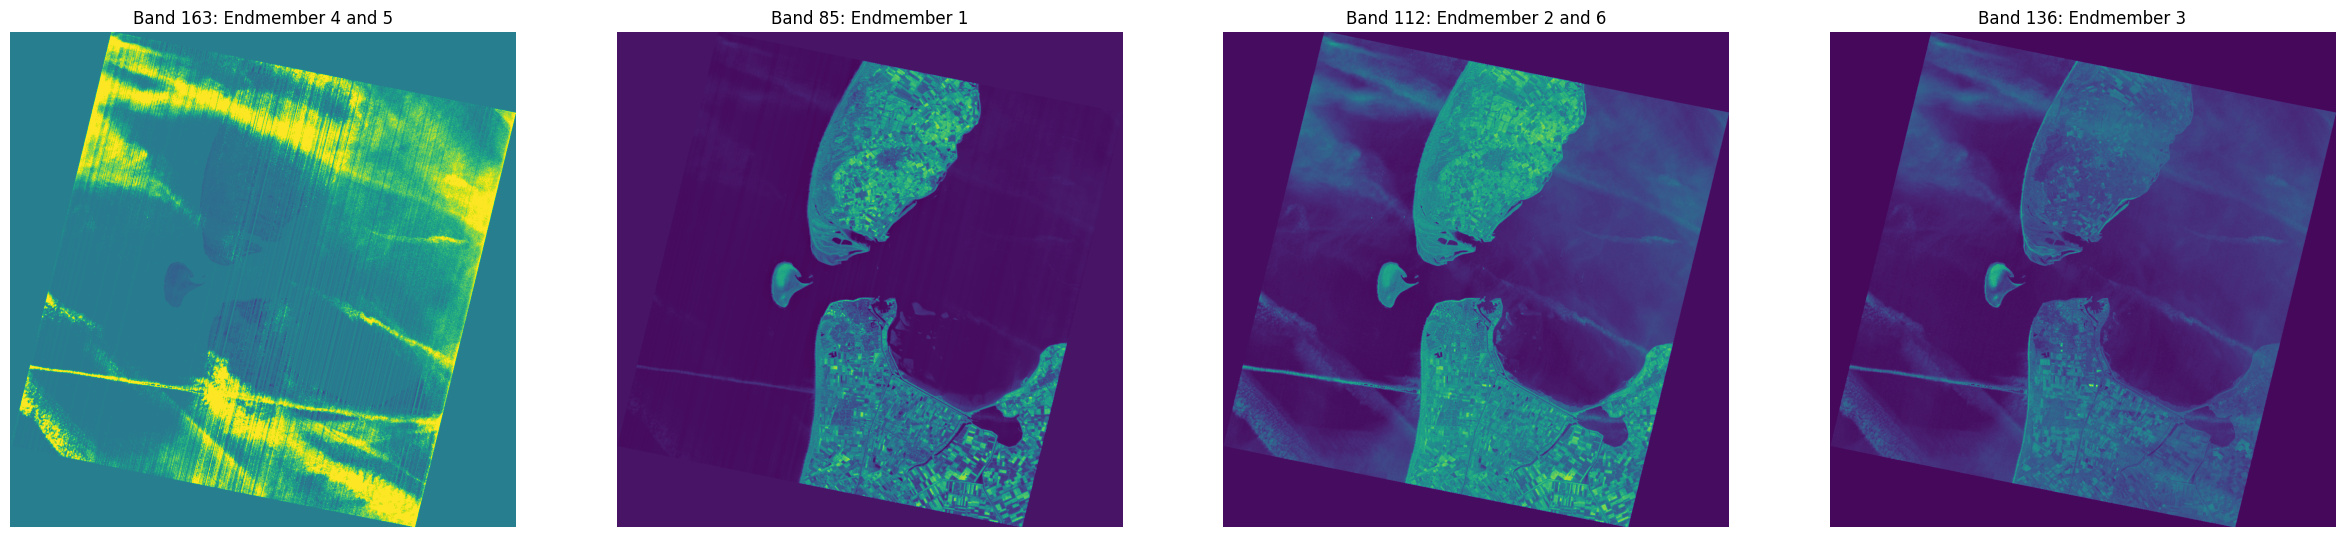

In [96]:
classes = result[0]

first_band = src_array[:, :, 85]
second_band = src_array[:, :, 112]
third_band = src_array[:, :, 136]
fourth_band = src_array[:, :, 163]

fig, axs = plt.subplots(1,4,figsize=(30, 60))
axs[0].imshow(TCI*alpha)
axs[0].set_title("TCI")
axs[0].axis("off")
axs[1].imshow(first_band)
axs[1].set_title("Band 85: Endmember 1")
axs[1].axis("off")
axs[2].imshow(second_band)
axs[2].set_title("Band 112: Endmember 2 and 6")
axs[2].axis("off")
axs[3].imshow(third_band)
axs[3].set_title("Band 136: Endmember 3")
axs[3].axis("off")
axs[0].imshow(fourth_band)
axs[0].set_title("Band 163: Endmember 4 and 5")
axs[0].axis("off")

In [67]:
num_comps = 16

nfindr = eea.NFINDR()
U = nfindr.extract(src_array, num_comps, normalize=True, ATGP_init=False)

In [68]:
bands = np.argmax(U, axis=1)
bands

array([136, 165, 163,  67, 112, 112,  67, 163, 136, 164, 112,  30, 112,
       163, 223, 163], dtype=int64)

In [73]:
bands.shape

(16,)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1235.5, 1210.5, -0.5)

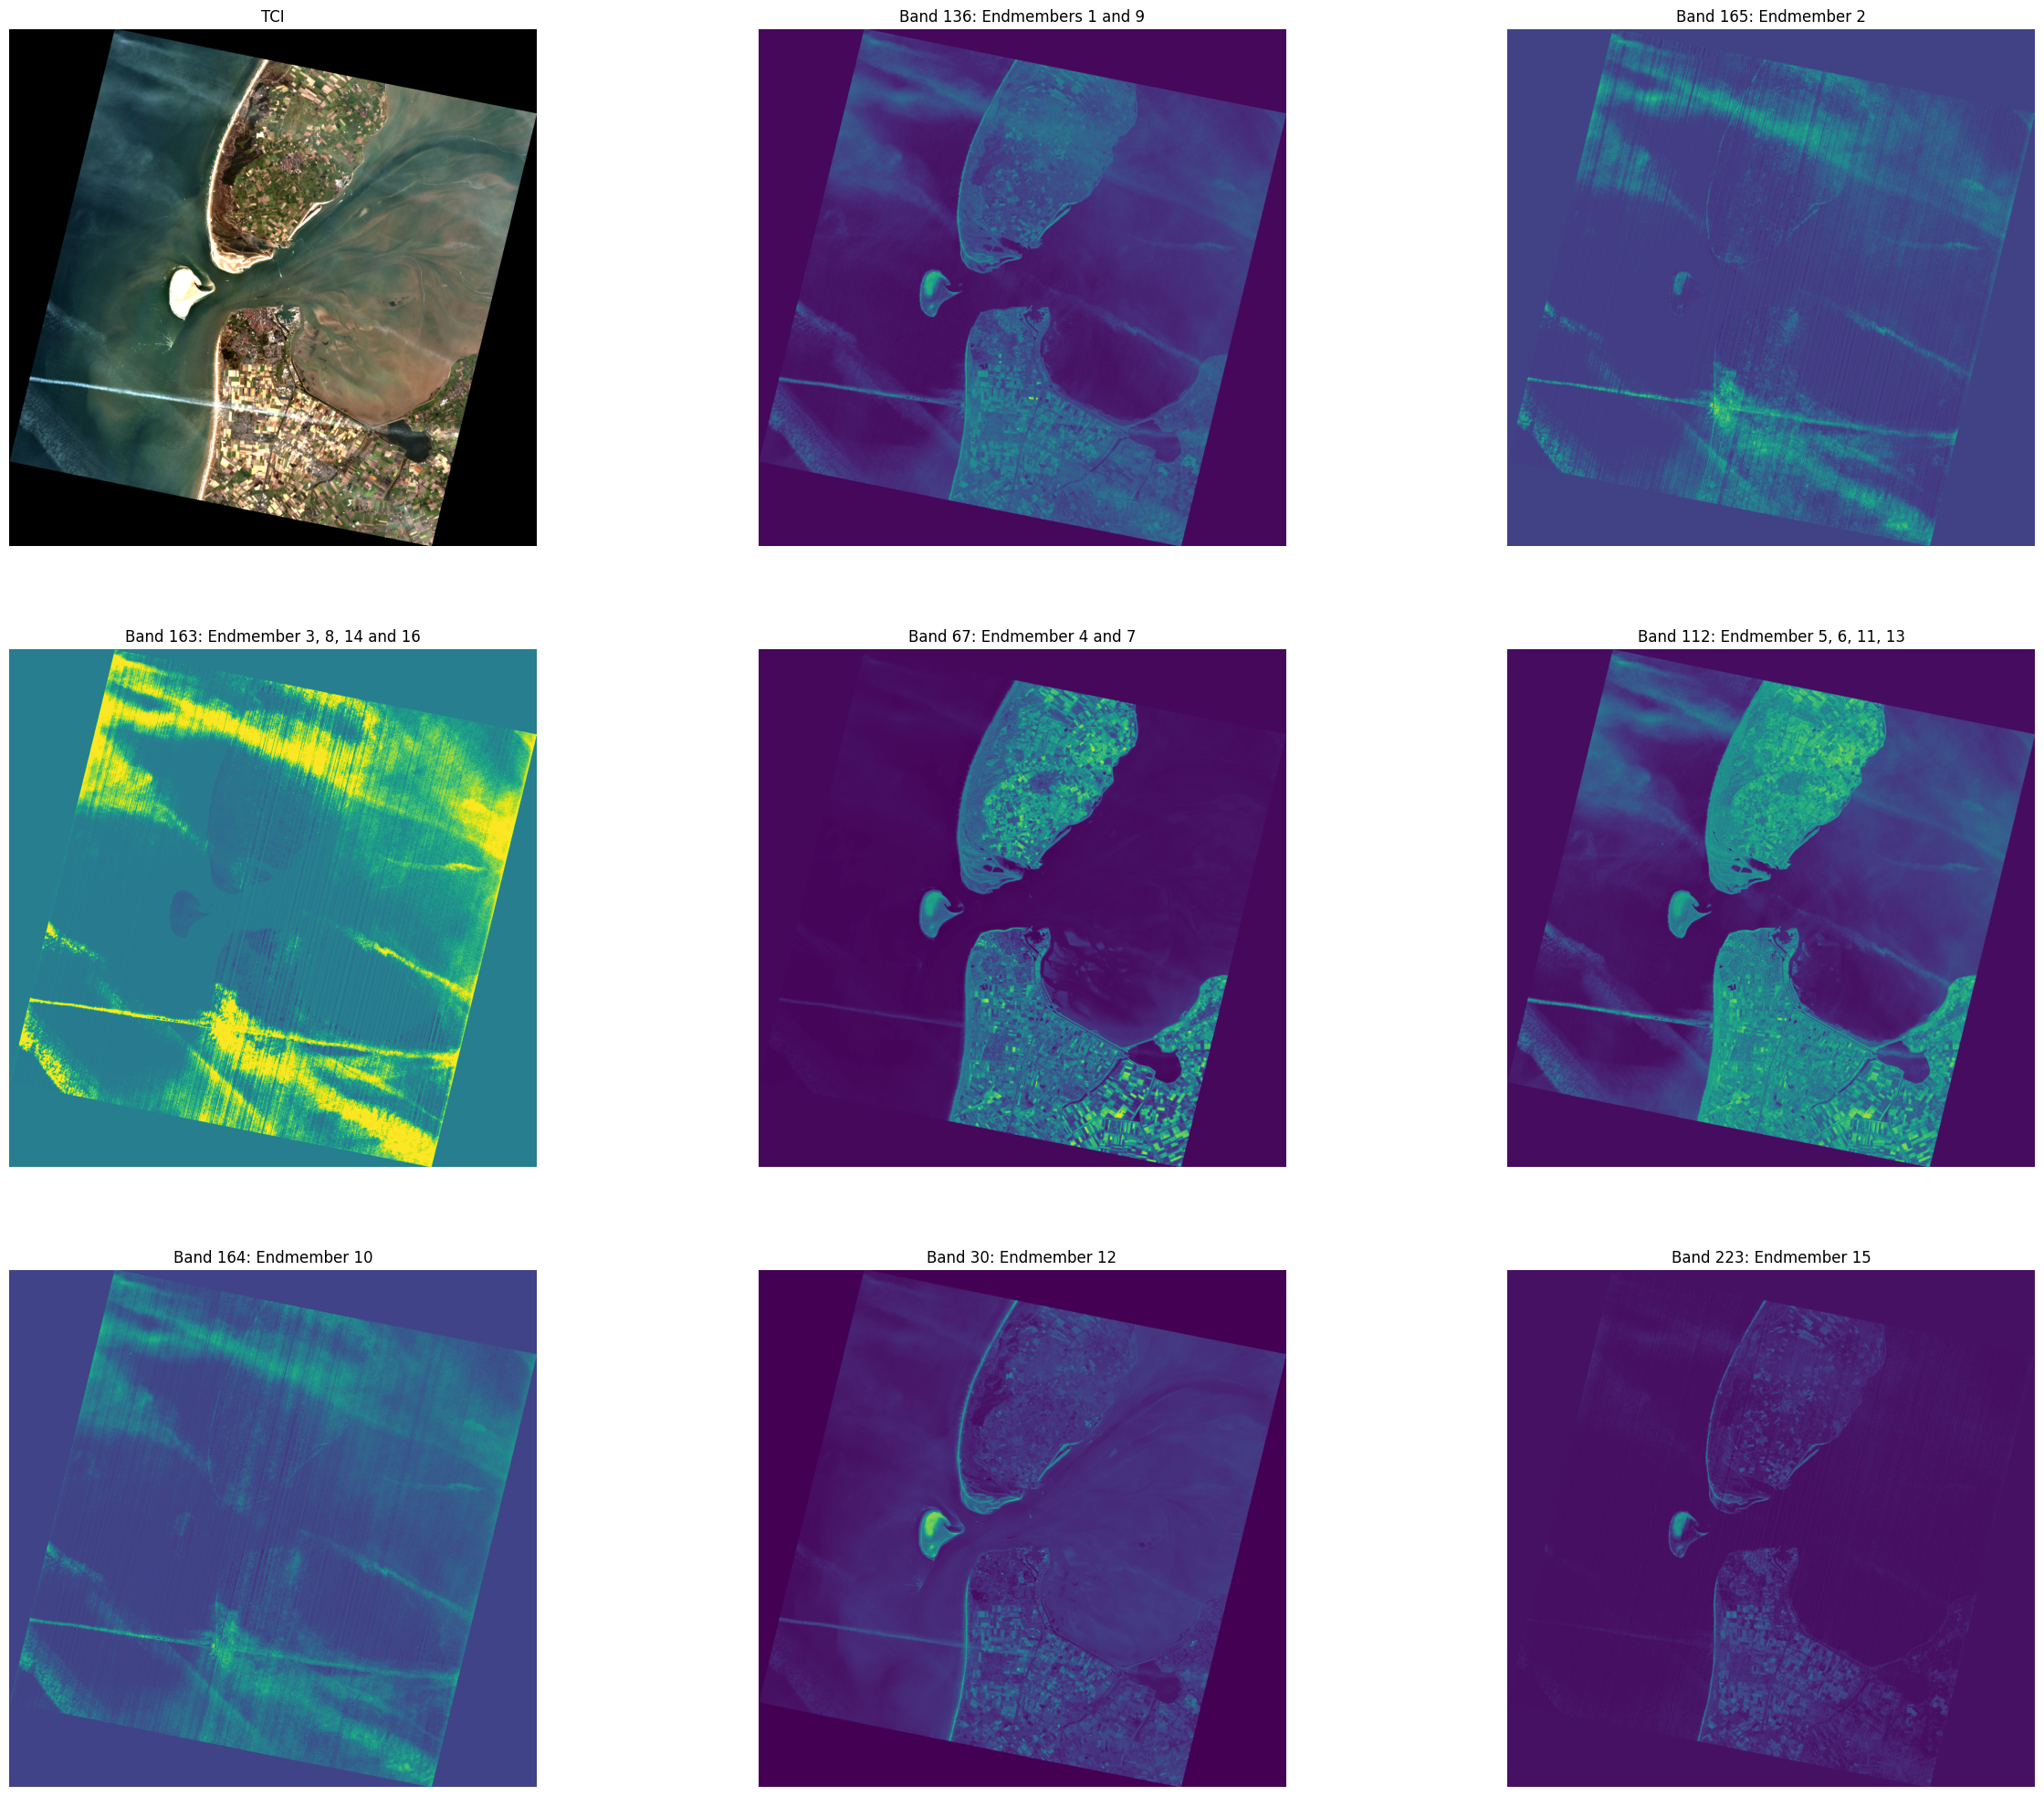

In [90]:
classes = result[0]

first_band = src_array[:, :, 136]
second_band = src_array[:, :, 165]
third_band = src_array[:, :, 163]
fourth_band = src_array[:, :, 67]
fifth_band = src_array[:, :, 112]
sixth_band = src_array[:, :, 164]
seventh_band = src_array[:, :, 30]
eighth_band = src_array[:, :, 223]


fig, axs = plt.subplots(3,3,figsize=(30, 25))
axs[0, 0].imshow(TCI*alpha)
axs[0, 0].set_title("TCI")
axs[0, 0].axis("off")
axs[0, 1].imshow(first_band)
axs[0, 1].set_title("Band 136: Endmembers 1 and 9")
axs[0, 1].axis("off")
axs[0, 2].imshow(second_band)
axs[0, 2].set_title("Band 165: Endmember 2")
axs[0, 2].axis("off")
axs[1, 0].imshow(third_band)
axs[1, 0].set_title("Band 163: Endmember 3, 8, 14 and 16")
axs[1, 0].axis("off")
axs[1, 1].imshow(fourth_band)
axs[1, 1].set_title("Band 67: Endmember 4 and 7")
axs[1, 1].axis("off")
axs[1, 2].imshow(fifth_band)
axs[1, 2].set_title("Band 112: Endmember 5, 6, 11, 13")
axs[1, 2].axis("off")
axs[2, 0].imshow(sixth_band)
axs[2, 0].set_title("Band 164: Endmember 10")
axs[2, 0].axis("off")
axs[2, 1].imshow(seventh_band)
axs[2, 1].set_title("Band 30: Endmember 12")
axs[2, 1].axis("off")
axs[2, 2].imshow(eighth_band)
axs[2, 2].set_title("Band 223: Endmember 15")
axs[2, 2].axis("off")

Possibly fun to explore: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html#sklearn.cluster.SpectralClustering